# Experiments across country 

## Outline:

Models trained on data from countries specified via "country_name":

- English options: "Australia", "Canada", "Ireland", "New Zealand", "United Kingdom", "United States", "South Africa"
- German options: "Luxembourg", "Italy", "Germany", "Austria", "Switzerland"
- French options: "Luxembourg", "France", "Switzerland", "Canada"

Available models specified via "model_checkpoint":

- English options: "bert-base-cased", "distilbert-base-cased"
- German options: "distilbert-base-german-cased"
- French options: "flaubert/flaubert_small_cased"

In [4]:
# Adjust paths if this does not return "manifesto-domaintransfer"
import os
os.getcwd()
os.chdir("..")

In [5]:
# select one country as hold-out set 
country_name = "South Africa" # name in the data set
country_short = "southafrica" # custom folder name for saving the results

In [14]:
# set all path and name variables
path_file = "data/multilingual_data_2018-2.csv" # same for all languages
model_checkpoint = "distilbert-base-cased" # adjust
model_name = model_checkpoint.split("/")[-1] # strip huggingface account names
path_results = "results/" + model_name + "/" + country_short
path_model = "models/"
model_append = country_short + "-manifesto-2018"

## Loading the packages, functions and dataset

In [7]:
from utils.BERT_utils import *

In [8]:
# set seeds for reproducibility
transformers.set_seed(3)
transformers.enable_full_determinism(3)
np.random.seed(3)

In [9]:
# load data
data = pd.read_csv(path_file,  index_col=None)

# ensure variables as string
data['topic_8'] = data['topic_8'].astype(str) # categories
data['text'] = data['text'].astype(str) # topic

## select the language

Execute one of the following cells, depending on which language you are interested in.

In [12]:
# select English speaking countries
countries = ["Australia", "Canada", "Ireland", "New Zealand", "United Kingdom", "United States", "South Africa"]
data_language = data.loc[data['countryname'].isin(countries), :]
data_language = data_language.loc[data_language['language'] =="english", :]
print(data_language.shape)
data_language.head(3) 

(114523, 7)


,countryname,text,language,code,document_index,date,topic_8
512801,United Kingdom,We face three connected crises: Healing the pl...,english,416.0,1,201505,economy
512802,United Kingdom,"Creating a more equal society, reversing the t...",english,503.0,1,201505,welfare and quality of life
512803,United Kingdom,Creating truly democratic central and local go...,english,202.0,1,201505,freedom and democracy


In [ ]:
# select German speaking countries
countries = ["Luxembourg", "Italy", "Germany", "Austria", "Switzerland"]
data_language = data.loc[data['countryname'].isin(countries), :]
data_language = data_language.loc[data_language['language'] == "german", :]
print(data_language.shape)
data_language.head(3) 

In [10]:
# select French speaking countries
countries = ["Luxembourg", "France", "Switzerland", "Canada"]
data_language = data.loc[data['countryname'].isin(countries), :]
data_language = data_language.loc[data_language['language'] == "french", :]
print(data_language.shape)
data_language.head(3) 

(114546, 7)
['United Kingdom' 'Ireland' 'United States' 'Canada' 'Australia'
 'New Zealand' 'Israel' 'South Africa']


,countryname,text,language,code,document_index,date,topic_8
512801,United Kingdom,We face three connected crises: Healing the pl...,english,416.0,1,201505,economy
512802,United Kingdom,"Creating a more equal society, reversing the t...",english,503.0,1,201505,welfare and quality of life
512803,United Kingdom,Creating truly democratic central and local go...,english,202.0,1,201505,freedom and democracy


## train/val/test split

In [37]:
# X: text, Y: topic
X = data_language['text'] 
Y = data_language['topic_8']

# Y numeric
Y_numeric = pd.factorize(Y)[0]
classes = pd.factorize(Y)[1]

# mapping: numeric -> category
dic_y_mapping = {n:label for n,label in enumerate(classes)}

# reverese mapping: catgory -> numeric
dic_y_mapping_inverse = dict(map(reversed, dic_y_mapping.items()))

In [38]:
# select one country as test set 
X_train = X[data_language['countryname'] != country_name]
X_test = X[data_language['countryname'] == country_name]

Y_numeric_train = Y_numeric[data_language['countryname'] != country_name]
Y_numeric_test = Y_numeric[data_language['countryname'] == country_name]

print(X_train.shape)
print(X_test.shape)
print(Y_numeric_train.shape)
print(Y_numeric_test.shape)

print(Y_numeric_test.shape[0]/ data.shape[0])


X_train, X_val, Y_numeric_train, Y_val = train_test_split(X_train, Y_numeric_train, train_size=0.8, random_state=77)

print('X_train', X_train.shape, round(X_train.shape[0]/X.shape[0], 2))
print('X_test', X_test.shape, round(X_test.shape[0]/X.shape[0], 2))
print('X_val', X_val.shape, round(X_val.shape[0]/X.shape[0], 2))

(108100,)
(6423,)
(108100,)
(6423,)
0.006448743383587281
X_train (86480,) 0.76
X_test (6423,) 0.06
X_val (21620,) 0.19


In [39]:
# create dataset for training
dataset = {'train':Dataset.from_dict({'label':Y_numeric_train,'text':X_train}),
     'validation':Dataset.from_dict({'label':Y_val,'text':X_val}),
     'test':Dataset.from_dict({'label':Y_numeric_test,'text':X_test})
     }
dataset = DatasetDict(dataset)

# structure data set
print(dataset)

# example
dataset["train"][0]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 86480
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 21620
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 6423
    })
})


{'label': 1,
 'text': '•  Increase data-matching  information in  benefit  applications with information held  by other  agencies  to make  identifying  fraudsters  easier.'}

## Preprocessing the data

In [15]:
# Chose model and corresponing tokenize
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
batch_size = 16

In [13]:
encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset

NameError: name 'dataset' is not defined

## Fine-tuning the model

In [43]:
metric = load_metric('f1')
metric_name = "f1"
num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.b

In [44]:
args = TrainingArguments(
    f"{path_model}{model_name}-{model_append}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    seed=0,
    #push_to_hub=True,
)

In [45]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [18]:
trainer.train()

C:\Users\ri85vex\Miniconda3\envs\manifesto\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········


wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [19]:
# saving the fine tuned model & tokenizer
model.save_pretrained(path_model + model_name + "-" + model_append)
tokenizer.save_pretrained(path_model + model_name + "-" + model_append)

('./drive/MyDrive/Paper BERT/results/01a_DistilBERT English/countries/South Africa/model/tokenizer_config.json',
 './drive/MyDrive/Paper BERT/results/01a_DistilBERT English/countries/South Africa/model/special_tokens_map.json',
 './drive/MyDrive/Paper BERT/results/01a_DistilBERT English/countries/South Africa/model/vocab.txt',
 './drive/MyDrive/Paper BERT/results/01a_DistilBERT English/countries/South Africa/model/added_tokens.json',
 './drive/MyDrive/Paper BERT/results/01a_DistilBERT English/countries/South Africa/model/tokenizer.json')

In [49]:
# load the saved model
tokenizer = AutoTokenizer.from_pretrained(path_model + model_name + "-" + model_append, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(path_model + model_name + "-" + model_append, num_labels=num_labels)

## Evaluation

In [25]:
trainer.evaluate(eval_dataset = encoded_dataset["test"])

{'eval_loss': 1.2574185132980347,
 'eval_f1': 0.4953687946213714,
 'eval_runtime': 13.4082,
 'eval_samples_per_second': 479.036,
 'eval_steps_per_second': 29.982,
 'epoch': 3.0}

In [26]:
# get predictions and evaluation metrices
Y_pred_testing, Y_test_classes = predict_BERT(encoded_dataset["test"], dic_y_mapping, Y_numeric_test)
evaluation_testing = evaluation_table(Y_test_classes, Y_pred_testing, domain= 'within-domain', data_description ="testing")
evaluation_testing 

,metric,score,domain,data
0,Accuracy,0.599720,within-domain,testing
1,F1 score (macro),0.495369,within-domain,testing


Accuracy: 0.6
Detail:


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,data
economy,0.528769,0.678505,0.594351,1070.0,testing
external relations,0.237716,0.752101,0.361251,238.0,testing
fabric of society,0.738295,0.593629,0.658106,1036.0,testing
freedom and democracy,0.645963,0.561151,0.600577,556.0,testing
no topic,0.000000,0.000000,0.000000,1.0,testing
political system,0.623053,0.387973,0.478183,1031.0,testing
social groups,0.643678,0.503748,0.565181,667.0,testing
welfare and quality of life,0.706659,0.703947,0.705301,1824.0,testing


<Figure size 640x480 with 0 Axes>

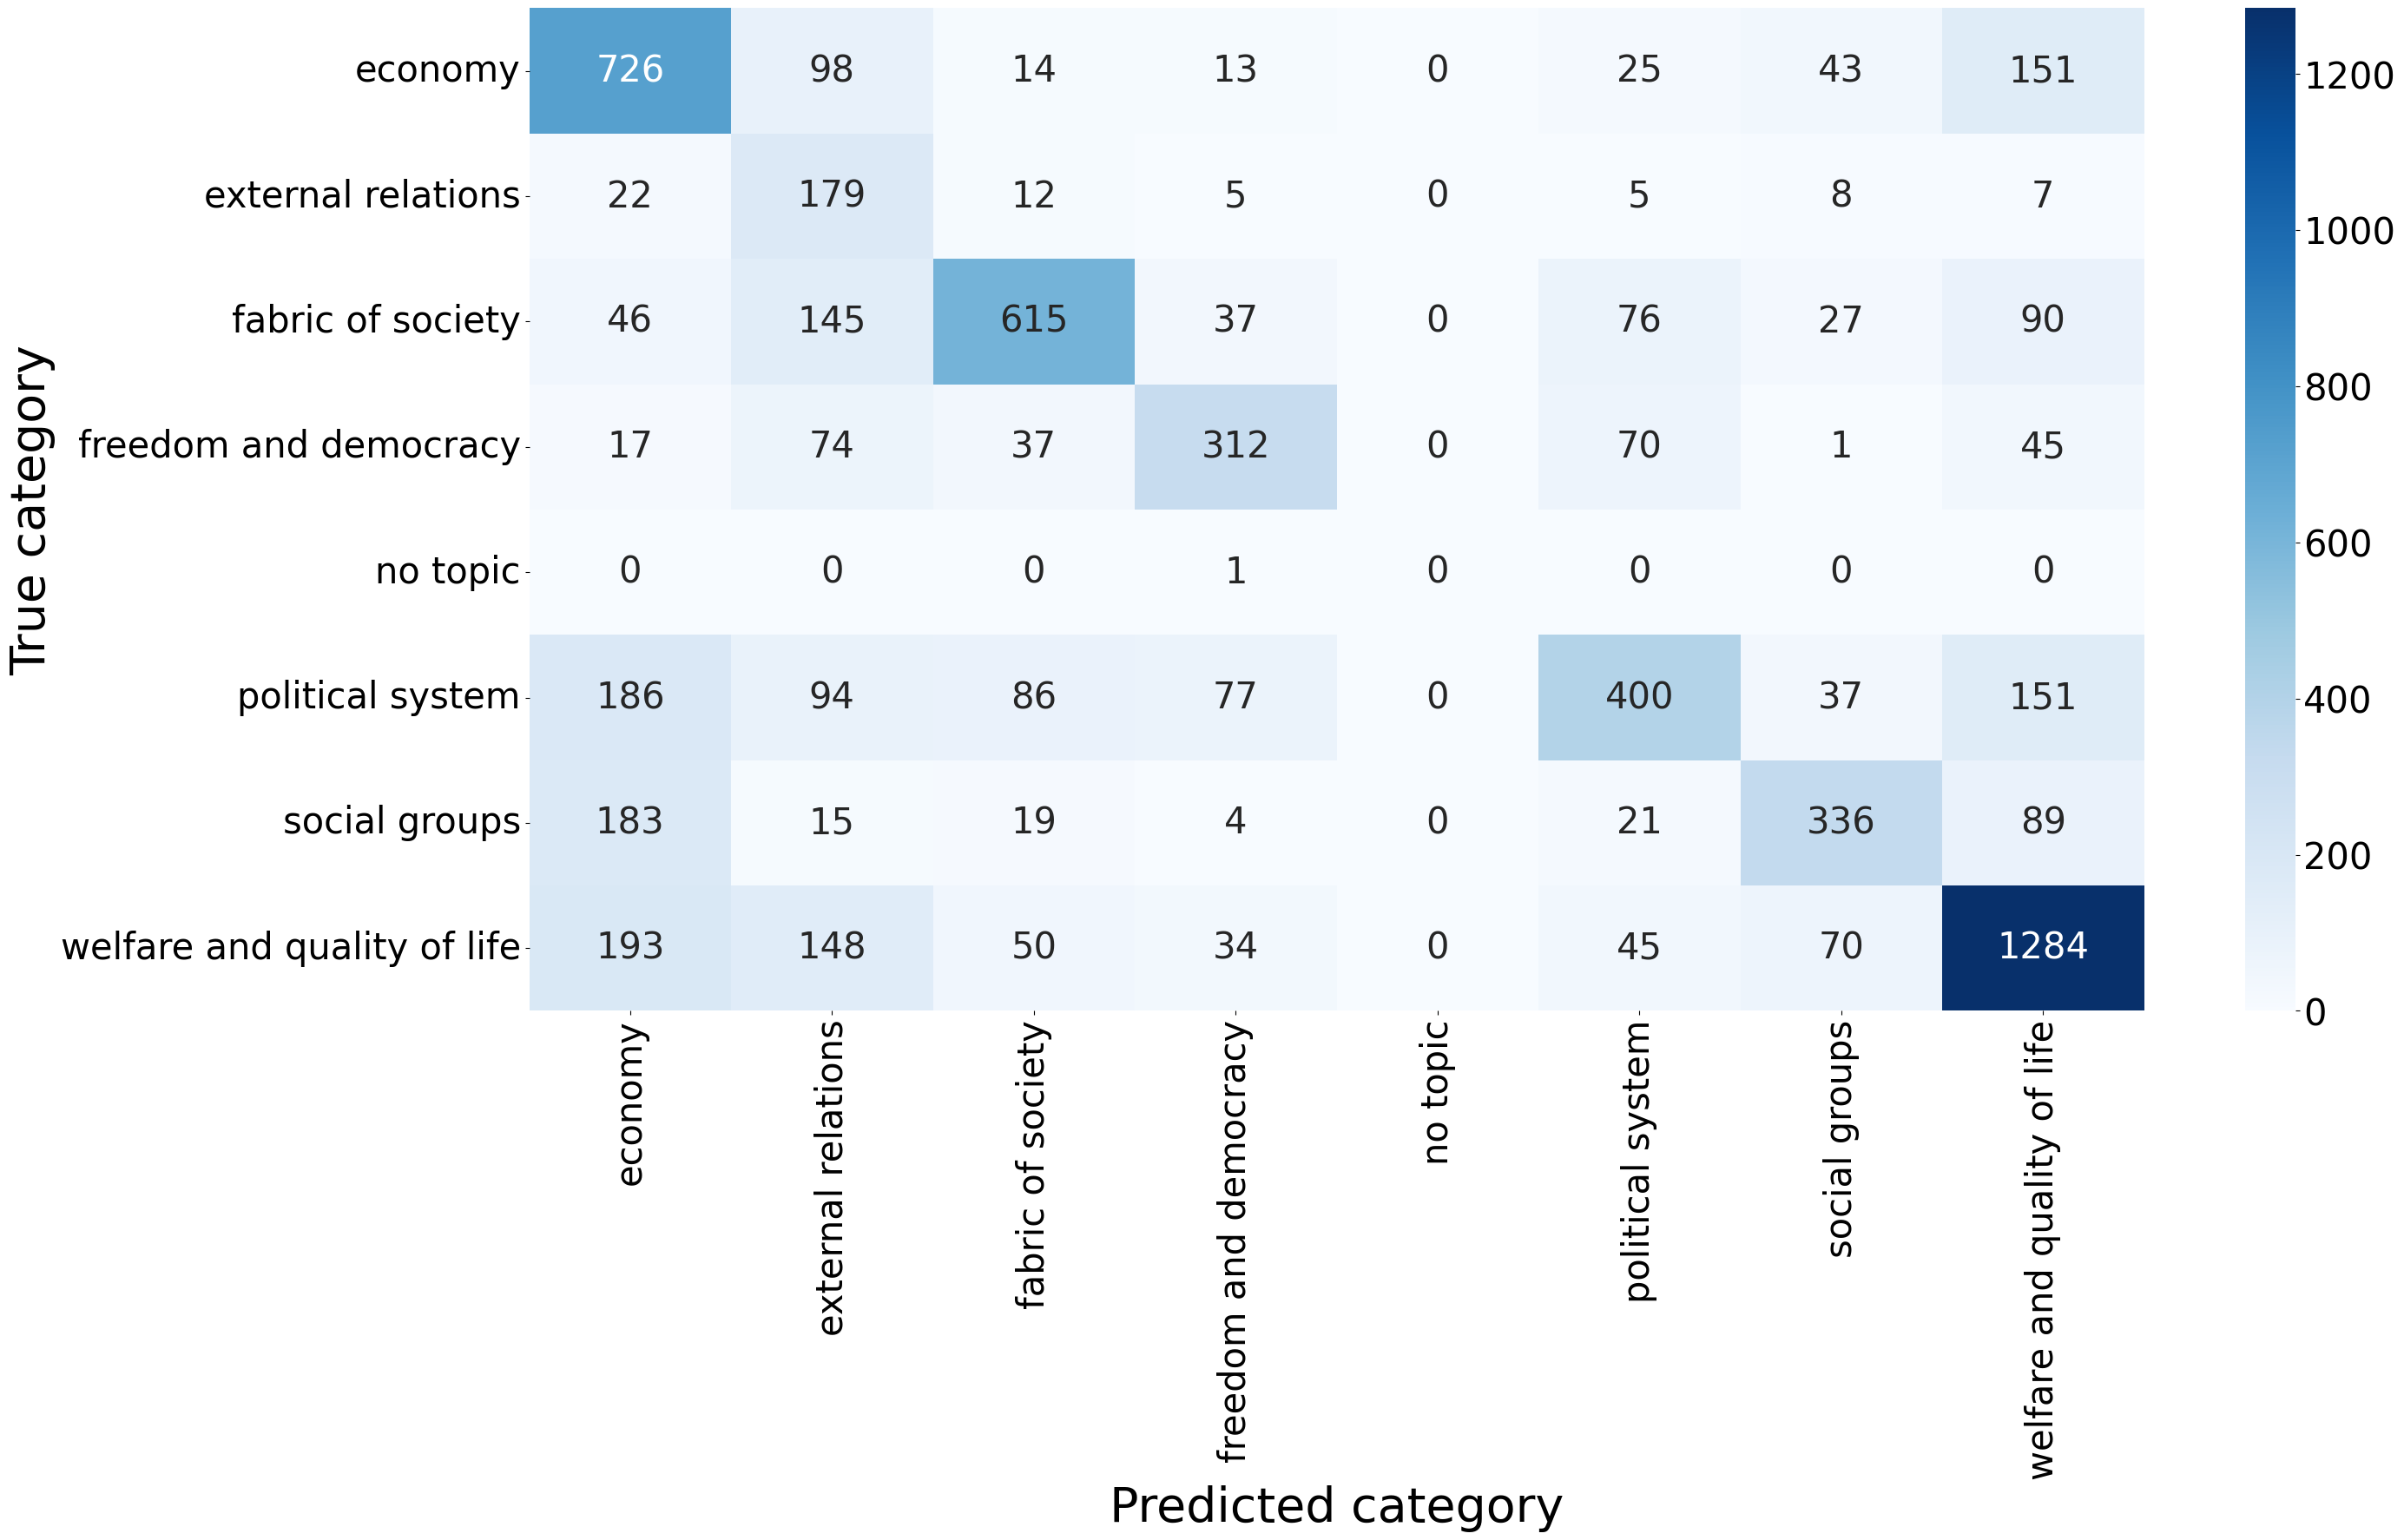

In [27]:
classification_report_testing = evaluation_per_category(Y_test_classes, Y_pred_testing, data_description ="testing", path_results = path_results, figsize=(30,15))
classification_report_testing

## Overview results

In [28]:
eval_metrics = pd.concat([evaluation_training, evaluation_validation, evaluation_testing])
eval_metrics.reset_index(drop = True, inplace = True)
eval_metrics.to_csv(path_results + '/eval_metrics.csv')
eval_metrics

,metric,score,domain,data
0,Accuracy,0.836425,within-domain,training
1,F1 score (macro),0.718746,within-domain,training
2,Accuracy,0.685060,within-domain,validation
3,F1 score (macro),0.563738,within-domain,validation
4,Accuracy,0.599720,within-domain,testing
5,F1 score (macro),0.495369,within-domain,testing
